# Data Analysis 3
## Assignment 3
### Abylaikhan Shaken
Predict v1 and v2 values for a whole month, with hourly variations.
Train models using historical data.
Use feature engineering to improve accuracy.
Implement XGBoost and Prophet models.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
%matplotlib inline

In [14]:
df = pd.read_csv('data.csv')

df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df.head()

,v1,v2
ts,,
2022-01-01 00:00:00,0.999036,0.318587
2022-01-01 01:00:00,0.695036,0.265836
2022-01-01 02:00:00,0.764995,0.320261
2022-01-01 03:00:00,0.297017,0.064074
2022-01-01 04:00:00,0.366184,0.083961


In [16]:
print('Data Shape:', df.shape)
print('\nMissing Values:\n', df.isnull().sum())

df.describe()

Data Shape: (24592, 2)

Missing Values:
 v1    0
v2    0
dtype: int64


,v1,v2
count,24592.000000,24592.000000
mean,1.385839,0.380771
std,1.154606,0.226058
min,0.000000,0.000000
25%,0.592698,0.194897
50%,1.017005,0.339869
75%,1.821109,0.554251
max,10.969931,0.978945


## Exploratory Data Analysis (EDA)

We will visually explore `v1` and `v2` to identify patterns, trends, and seasonality.


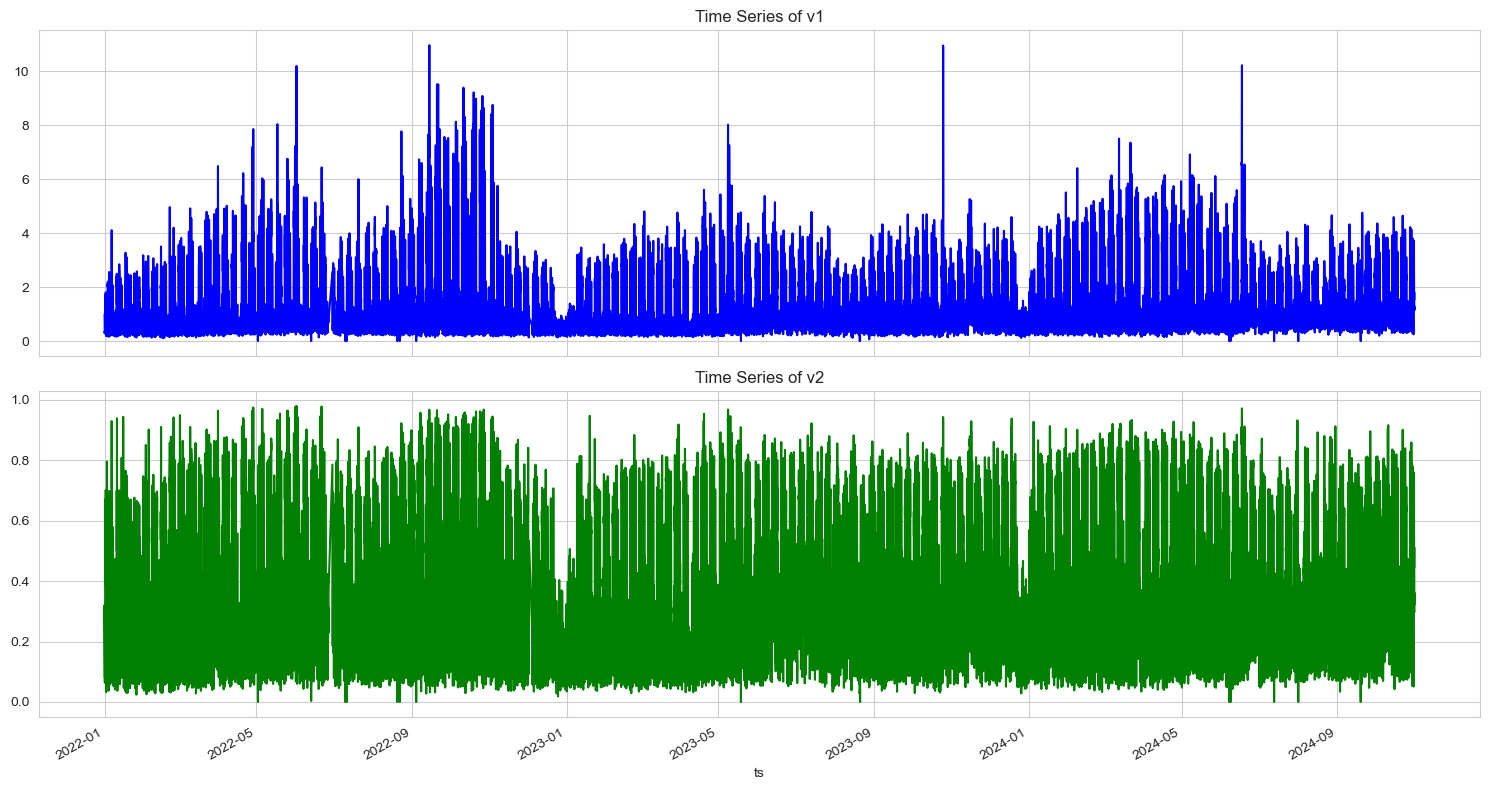

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

df['v1'].plot(ax=axes[0], color='blue', title='Time Series of v1')
df['v2'].plot(ax=axes[1], color='green', title='Time Series of v2')

plt.tight_layout()
plt.show()

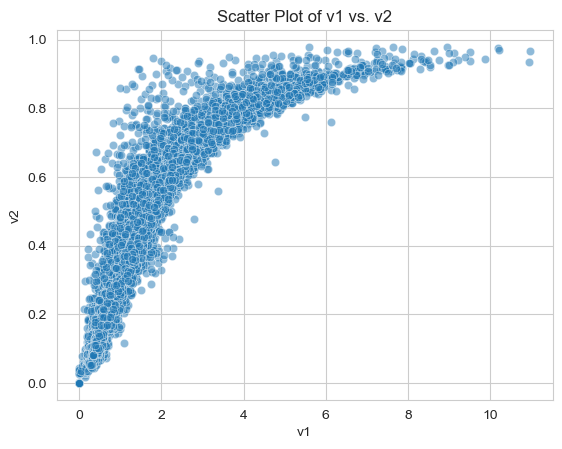

Correlation between v1 and v2: 0.91


In [23]:
sns.scatterplot(data=df, x='v1', y='v2', alpha=0.5)
plt.title('Scatter Plot of v1 vs. v2')
plt.show()

corr = df['v1'].corr(df['v2'])
print(f"Correlation between v1 and v2: {corr:.2f}")


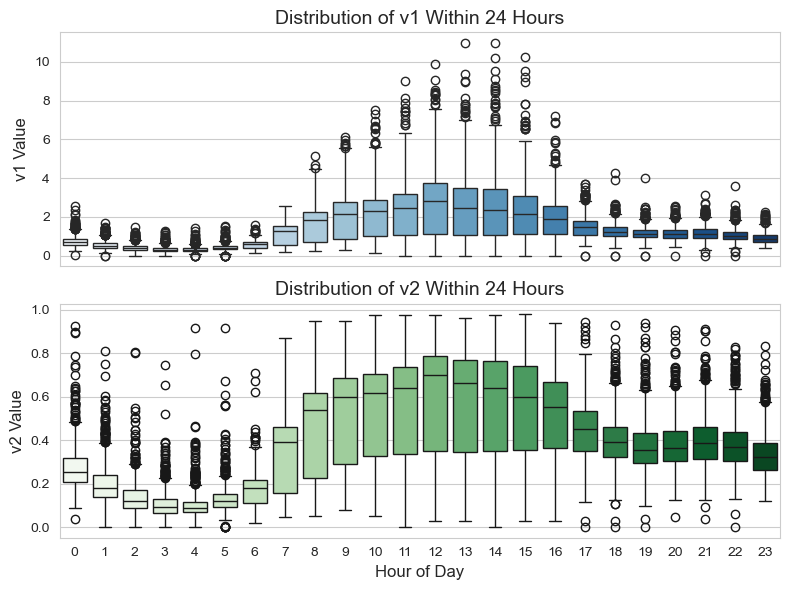

In [33]:
def plot_daily_fluctuations(df):
    df['hour'] = df.index.hour  

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    
    sns.boxplot(x=df['hour'], y=df['v1'], ax=axes[0], palette='Blues')
    axes[0].set_title('Distribution of v1 Within 24 Hours', fontsize=14)
    axes[0].set_xlabel('Hour of Day', fontsize=12)
    axes[0].set_ylabel('v1 Value', fontsize=12)
    
    sns.boxplot(x=df['hour'], y=df['v2'], ax=axes[1], palette='Greens')
    axes[1].set_title('Distribution of v2 Within 24 Hours', fontsize=14)
    axes[1].set_xlabel('Hour of Day', fontsize=12)
    axes[1].set_ylabel('v2 Value', fontsize=12)
    
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

plot_daily_fluctuations(df)

# We can see interesting pattern where value of v1 increases during the day and decreases during the night, impying it is related to human activity

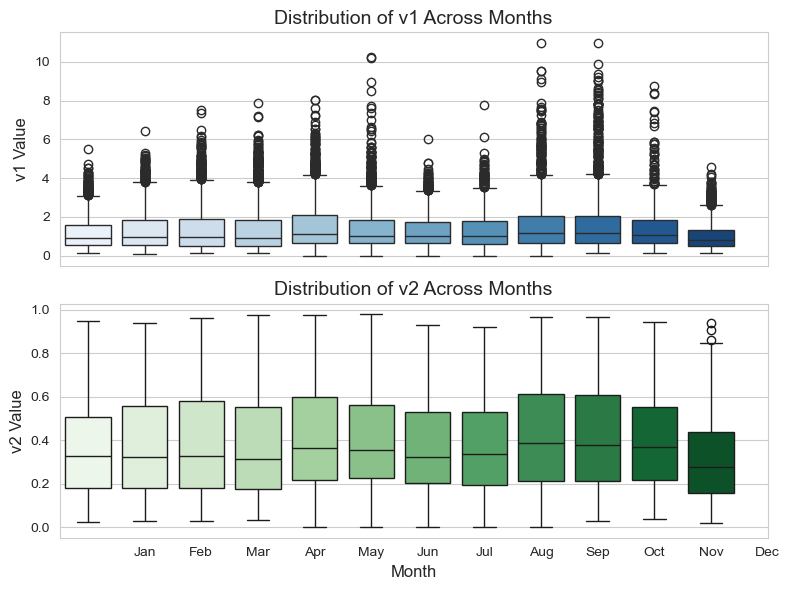

In [31]:
def plot_monthly_fluctuations(df):
    df['month'] = df.index.month 

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    sns.boxplot(x=df['month'], y=df['v1'], ax=axes[0], palette='Blues')
    axes[0].set_title('Distribution of v1 Across Months', fontsize=14)
    axes[0].set_xlabel('Month', fontsize=12)
    axes[0].set_ylabel('v1 Value', fontsize=12)

    sns.boxplot(x=df['month'], y=df['v2'], ax=axes[1], palette='Greens')
    axes[1].set_title('Distribution of v2 Across Months', fontsize=14)
    axes[1].set_xlabel('Month', fontsize=12)
    axes[1].set_ylabel('v2 Value', fontsize=12)

    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()

plot_monthly_fluctuations(df)

# We can see that November has lowest results for v1 and v2
# This might be an issue when forecasting, because starting point will be October
# Also this implies to use past Novembers as good comparison to forecasted one

## Feature Engineering

We create additional features that might improve forecasting performance:
- Lagged values.
- Rolling averages.
- Time-based features.


In [51]:
from sklearn.preprocessing import StandardScaler

# Lag features (short-term memory)
# I increased duration to a month, because November is unique month
for lag in [1, 24, 168, 336, 720]:  # Previous hour, day, week, two weeks, month
    df[f'v1_lag_{lag}'] = df['v1'].shift(lag)
    df[f'v2_lag_{lag}'] = df['v2'].shift(lag)

# Rolling averages (daily, weekly, and monthly)
# I increased duration to a month, because November is unique month
for window in [24, 168, 336, 720]:  # 1 day, 1 week, 2 weeks, 1 month
    df[f'v1_roll_mean_{window}'] = df['v1'].rolling(window=window).mean()
    df[f'v2_roll_mean_{window}'] = df['v2'].rolling(window=window).mean()

# Rolling standard deviations (volatility indicators)
for window in [24, 168, 336]:
    df[f'v1_roll_std_{window}'] = df['v1'].rolling(window=window).std()
    df[f'v2_roll_std_{window}'] = df['v2'].rolling(window=window).std()

# Exponential Moving Averages (EMA) - faster response to changes
for span in [24, 168, 336]:
    df[f'v1_exp_ma_{span}'] = df['v1'].ewm(span=span, adjust=False).mean()
    df[f'v2_exp_ma_{span}'] = df['v2'].ewm(span=span, adjust=False).mean()

# Lag Differences (Capturing sudden jumps or drops)
for diff in [1, 24, 168]:  # Change from last hour, day, week
    df[f'v1_diff_{diff}'] = df['v1'].diff(diff)
    df[f'v2_diff_{diff}'] = df['v2'].diff(diff)

# Ratio Features (Understanding v1 and v2 relationships)
df['v1_v2_ratio'] = df['v1'] / (df['v2'] + 1e-6)  # Avoid division by zero
df['v2_v1_ratio'] = df['v2'] / (df['v1'] + 1e-6)

# Time-based features (for capturing periodicity)
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Fourier Features for capturing seasonality
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_dayofweek'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_dayofweek'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

# Weekend Indicator (For different patterns on weekends)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

# Standardization (XGBoost handles unscaled data, but scaling may help)
scaler = StandardScaler()
scaled_features = [col for col in df.columns if 'lag' in col or 'roll_mean' in col or 'exp_ma' in col]
df[scaled_features] = scaler.fit_transform(df[scaled_features])

df.dropna(inplace=True)
df.head()

,v1,v2,Month,month,hour,v1_lag_1,v2_lag_1,v1_lag_24,v2_lag_24,v1_lag_168,...,v1_roll_std_168,v2_roll_std_168,v1_roll_std_336,v2_roll_std_336,v1_diff_1,v2_diff_1,v1_diff_24,v2_diff_24,v1_diff_168,v2_diff_168
ts,,,,,,,,,,,,,,,,,,,,,
2022-04-01 01:00:00,0.812759,0.384584,Apr,4,1,-0.375174,-0.637729,-0.881948,-1.062541,-0.525060,...,1.307921,0.247446,1.244212,0.244982,-0.151360,0.146878,0.443153,0.243316,0.025411,0.034382
2022-04-01 02:00:00,0.274429,0.108797,Apr,4,2,-0.504255,0.009336,-0.958363,-1.142091,-0.412347,...,1.310724,0.248593,1.244307,0.245129,-0.538331,-0.275788,-0.005561,-0.014415,-0.645238,-0.212610
2022-04-01 03:00:00,0.253749,0.112759,Apr,4,3,-0.963349,-1.205635,-0.951864,-1.213438,-0.584501,...,1.312964,0.248907,1.244290,0.244882,-0.020680,0.003963,-0.033863,0.005743,-0.463818,-0.043101
2022-04-01 04:00:00,0.197595,0.081385,Apr,4,4,-0.980985,-1.188179,-0.946305,-1.199156,-0.544731,...,1.315699,0.250149,1.244275,0.244688,-0.056154,-0.031374,-0.096536,-0.028874,-0.566660,-0.204112
2022-04-01 05:00:00,0.309193,0.106768,Apr,4,5,-1.028874,-1.326398,-0.862784,-1.177596,-0.649562,...,1.317304,0.251409,1.243999,0.244477,0.111598,0.025383,-0.082889,-0.008385,-0.331996,-0.278722


## Train-Test Split

Split data into training and validation sets:
- Train: Data before September 2024
- Validation: September and October 2024


In [56]:
train = df[:'2024-08-31 23:00']
validation = df['2024-09-01 00:00':]

print('Training set:', train.shape)
print('Validation set:', validation.shape)


Training set: (20992, 51)
Validation set: (1440, 51)


## Model 1: GLM

In [63]:
from patsy import dmatrices
import statsmodels.api as sm

df.fillna(method='ffill', inplace=True)  # Fill missing values

regressors_v1 = [
    'v1_lag_1', 'v1_lag_24', 'v1_lag_168', 'v1_lag_336', 'v1_lag_720',
    'v1_roll_mean_24', 'v1_roll_mean_168', 'v1_roll_mean_336', 'v1_roll_mean_720',
    'v1_roll_std_24', 'v1_roll_std_168', 'v1_roll_std_336',
    'v1_exp_ma_24', 'v1_exp_ma_168', 'v1_exp_ma_336',
    'v1_v2_ratio',  # Relationship with v2
    'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month',
    'day_of_week', 'month', 'is_weekend'
]

regressors_v2 = [
    'v2_lag_1', 'v2_lag_24', 'v2_lag_168', 'v2_lag_336', 'v2_lag_720',
    'v2_roll_mean_24', 'v2_roll_mean_168', 'v2_roll_mean_336', 'v2_roll_mean_720',
    'v2_roll_std_24', 'v2_roll_std_168', 'v2_roll_std_336',
    'v2_exp_ma_24', 'v2_exp_ma_168', 'v2_exp_ma_336',
    'v2_v1_ratio',  # Relationship with v1
    'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month',
    'day_of_week', 'month', 'is_weekend'
]

# These same regressors will be used on all models below

In [67]:
formula_v1 = "v1 ~ " + " + ".join(regressors_v1)

y_train_v1, X_train_v1 = dmatrices(formula_v1, train, return_type='dataframe')
y_valid_v1, X_valid_v1 = dmatrices(formula_v1, validation, return_type='dataframe')

# Train GLM Model for v1
model_glm_v1 = sm.OLS(y_train_v1, X_train_v1).fit()

# Predict & Evaluate for v1
y_pred_glm_v1 = model_glm_v1.predict(X_valid_v1)
rmse_glm_v1 = np.sqrt(mean_squared_error(y_valid_v1, y_pred_glm_v1))
r2_glm_v1 = r2_score(y_valid_v1, y_pred_glm_v1)
mae_glm_v1 = mean_absolute_error(y_valid_v1, y_pred_glm_v1)

print(f"GLM Validation RMSE (v1): {rmse_glm_v1:.4f}")
print(f"GLM Validation MAE (v1): {mae_glm_v1:.4f}")
print(f"GLM Validation R² (v1): {r2_glm_v1:.4f}")

formula_v2 = "v2 ~ " + " + ".join(regressors_v2)
y_train_v2, X_train_v2 = dmatrices(formula_v2, train, return_type='dataframe')
y_valid_v2, X_valid_v2 = dmatrices(formula_v2, validation, return_type='dataframe')

model_glm_v2 = sm.OLS(y_train_v2, X_train_v2).fit()

y_pred_glm_v2 = model_glm_v2.predict(X_valid_v2)
rmse_glm_v2 = np.sqrt(mean_squared_error(y_valid_v2, y_pred_glm_v2))
r2_glm_v2 = r2_score(y_valid_v2, y_pred_glm_v2)
mae_glm_v2 = mean_absolute_error(y_valid_v2, y_pred_glm_v2)

print(f"GLM Validation RMSE (v2): {rmse_glm_v2:.4f}")
print(f"GLM Validation MAE (v2): {mae_glm_v2:.4f}")
print(f"GLM Validation R² (v2): {r2_glm_v2:.4f}")

# GLM with 25 variables performed good, as a good benchmark for future models

GLM Validation RMSE (v1): 0.3627
GLM Validation MAE (v1): 0.2731
GLM Validation R² (v1): 0.8473
GLM Validation RMSE (v2): 0.0888
GLM Validation MAE (v2): 0.0641
GLM Validation R² (v2): 0.8226


## Model 2: Prophet

In [74]:
from prophet import Prophet

# Prepare data for Prophet with regressors
def prepare_prophet_data(df, target, regressors):
    data = df.reset_index().rename(columns={'ts': 'ds', target: 'y'})
    return data[['ds', 'y'] + regressors]

# Prepare training and validation datasets
prophet_train_v1 = prepare_prophet_data(train, 'v1', regressors_v1)
prophet_valid_v1 = prepare_prophet_data(validation, 'v1', regressors_v1)
prophet_train_v2 = prepare_prophet_data(train, 'v2', regressors_v2)
prophet_valid_v2 = prepare_prophet_data(validation, 'v2', regressors_v2)

# Train Prophet model for v1
model_prophet_v1 = Prophet()
for reg in regressors_v1:
    model_prophet_v1.add_regressor(reg)
model_prophet_v1.fit(prophet_train_v1)

# Train Prophet model for v2
model_prophet_v2 = Prophet()
for reg in regressors_v2:
    model_prophet_v2.add_regressor(reg)
model_prophet_v2.fit(prophet_train_v2)

# Make predictions
forecast_v1 = model_prophet_v1.predict(prophet_valid_v1)
forecast_v2 = model_prophet_v2.predict(prophet_valid_v2)

# Extract predictions
prophet_pred_v1 = forecast_v1.set_index('ds')['yhat']
prophet_pred_v2 = forecast_v2.set_index('ds')['yhat']

# Evaluate Prophet models
rmse_p_v1 = mean_squared_error(validation['v1'], prophet_pred_v1, squared=False)
mae_p_v1 = mean_absolute_error(validation['v1'], prophet_pred_v1)
r2_p_v1 = r2_score(validation['v1'], prophet_pred_v1)

rmse_p_v2 = mean_squared_error(validation['v2'], prophet_pred_v2, squared=False)
mae_p_v2 = mean_absolute_error(validation['v2'], prophet_pred_v2)
r2_p_v2 = r2_score(validation['v2'], prophet_pred_v2)

# Print evaluation metrics
print(f"Prophet v1 - RMSE: {rmse_p_v1:.3f}, MAE: {mae_p_v1:.3f}, R²: {r2_p_v1:.3f}")
print(f"Prophet v2 - RMSE: {rmse_p_v2:.3f}, MAE: {mae_p_v2:.3f}, R²: {r2_p_v2:.3f}")

# Prophet perfomed similarly to GLM when it comes to v1
# But slightly better with v1
# I need to look for another model

16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing
16:35:19 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet v1 - RMSE: 0.367, MAE: 0.272, R²: 0.844
Prophet v2 - RMSE: 0.084, MAE: 0.060, R²: 0.840


## Model 3: XGBoost

In [76]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare training and validation datasets
X_train_v1, y_train_v1 = train[regressors_v1], train['v1']
X_valid_v1, y_valid_v1 = validation[regressors_v1], validation['v1']

X_train_v2, y_train_v2 = train[regressors_v2], train['v2']
X_valid_v2, y_valid_v2 = validation[regressors_v2], validation['v2']

# Train XGBoost models
xgb_model_v1 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6)
xgb_model_v2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6)

xgb_model_v1.fit(X_train_v1, y_train_v1)
xgb_model_v2.fit(X_train_v2, y_train_v2)

# Make predictions
xgb_pred_v1 = xgb_model_v1.predict(X_valid_v1)
xgb_pred_v2 = xgb_model_v2.predict(X_valid_v2)

# Evaluate XGBoost models
rmse_xgb_v1 = mean_squared_error(y_valid_v1, xgb_pred_v1, squared=False)
mae_xgb_v1 = mean_absolute_error(y_valid_v1, xgb_pred_v1)
r2_xgb_v1 = r2_score(y_valid_v1, xgb_pred_v1)

rmse_xgb_v2 = mean_squared_error(y_valid_v2, xgb_pred_v2, squared=False)
mae_xgb_v2 = mean_absolute_error(y_valid_v2, xgb_pred_v2)
r2_xgb_v2 = r2_score(y_valid_v2, xgb_pred_v2)

# Print evaluation metrics
print(f"XGBoost v1 - RMSE: {rmse_xgb_v1:.3f}, MAE: {mae_xgb_v1:.3f}, R²: {r2_xgb_v1:.3f}")
print(f"XGBoost v2 - RMSE: {rmse_xgb_v2:.3f}, MAE: {mae_xgb_v2:.3f}, R²: {r2_xgb_v2:.3f}")

# XGBoost provided much better results for both v1 and v2

XGBoost v1 - RMSE: 0.232, MAE: 0.161, R²: 0.937
XGBoost v2 - RMSE: 0.071, MAE: 0.047, R²: 0.887


In [78]:
comparison_df = pd.DataFrame({
    "Model": ["GLM", "Prophet", "XGBoost"],
    "RMSE v1": [rmse_glm_v1, rmse_p_v1, rmse_xgb_v1],
    "MAE v1": [mae_glm_v1, mae_p_v1, mae_xgb_v1],
    "R2 v1": [r2_glm_v1, r2_p_v1, r2_xgb_v1],
    "RMSE v2": [rmse_glm_v2, rmse_p_v2, rmse_xgb_v2],
    "MAE v2": [mae_glm_v2, mae_p_v2, mae_xgb_v2],
    "R2 v2": [r2_glm_v2, r2_p_v2, r2_xgb_v2]
})
comparison_df

,Model,RMSE v1,MAE v1,R2 v1,RMSE v2,MAE v2,R2 v2
0,GLM,0.362651,0.273135,0.847294,0.088783,0.064054,0.822585
1,Prophet,0.367074,0.271725,0.843547,0.084384,0.059905,0.839731
2,XGBoost,0.232395,0.161036,0.937291,0.070960,0.047440,0.886667


### The best Model is XGBoost in all aspects as RMSE, MAE, R2
It will be used now to forecast November.  Surprisingly results for v1 of GLM and Prophet are identical
### Prediction

In [87]:
forecast_hours = pd.date_range('2024-11-01 00:00', '2024-11-30 23:00', freq='H')
forecast_df_xgb = pd.DataFrame(index=forecast_hours, columns=['v1', 'v2'])

# Ensure feature consistency
expected_features_v1 = X_train_v1.columns.tolist()
expected_features_v2 = X_train_v2.columns.tolist()

def align_features(X_pred, expected_features):
    for col in expected_features:
        if col not in X_pred:
            X_pred[col] = 0  # Assign default value if missing
    return X_pred[expected_features]  # Ensure correct order

# Start with last known values
last_row = df.iloc[-1]

for current_time in forecast_hours:
    X_pred_v1 = pd.DataFrame({
        'v1_lag_1': [last_row['v1']],
        'v1_lag_24': [df.loc[current_time - pd.Timedelta(hours=24), 'v1']] if current_time - pd.Timedelta(hours=24) in df.index else last_row['v1'],
        'v1_lag_168': [df.loc[current_time - pd.Timedelta(hours=168), 'v1']] if current_time - pd.Timedelta(hours=168) in df.index else last_row['v1'],
        'v1_roll_mean_24': [df['v1'].rolling(24).mean().iloc[-1]],
        'v1_roll_mean_168': [df['v1'].rolling(168).mean().iloc[-1]],
        'v1_exp_ma_24': [df['v1'].ewm(span=24, adjust=False).mean().iloc[-1]],
        'sin_hour': [np.sin(2 * np.pi * current_time.hour / 24)],
        'cos_hour': [np.cos(2 * np.pi * current_time.hour / 24)],
        'sin_dayofweek': [np.sin(2 * np.pi * current_time.dayofweek / 7)],
        'cos_dayofweek': [np.cos(2 * np.pi * current_time.dayofweek / 7)],
        'day_of_week': [current_time.dayofweek],
        'month': [current_time.month]
    })
    X_pred_v1 = align_features(X_pred_v1, expected_features_v1)
    pred_v1 = max(0, xgb_model_v1.predict(X_pred_v1)[0])  # Ensure non-negative values

    X_pred_v2 = pd.DataFrame({
        'v2_lag_1': [last_row['v2']],
        'v2_lag_24': [df.loc[current_time - pd.Timedelta(hours=24), 'v2']] if current_time - pd.Timedelta(hours=24) in df.index else last_row['v2'],
        'v2_lag_168': [df.loc[current_time - pd.Timedelta(hours=168), 'v2']] if current_time - pd.Timedelta(hours=168) in df.index else last_row['v2'],
        'v2_roll_mean_24': [df['v2'].rolling(24).mean().iloc[-1]],
        'v2_roll_mean_168': [df['v2'].rolling(168).mean().iloc[-1]],
        'v2_exp_ma_24': [df['v2'].ewm(span=24, adjust=False).mean().iloc[-1]],
        'sin_hour': [np.sin(2 * np.pi * current_time.hour / 24)],
        'cos_hour': [np.cos(2 * np.pi * current_time.hour / 24)],
        'sin_dayofweek': [np.sin(2 * np.pi * current_time.dayofweek / 7)],
        'cos_dayofweek': [np.cos(2 * np.pi * current_time.dayofweek / 7)],
        'day_of_week': [current_time.dayofweek],
        'month': [current_time.month]
    })
    X_pred_v2 = align_features(X_pred_v2, expected_features_v2)
    pred_v2 = max(0, xgb_model_v2.predict(X_pred_v2)[0])  # Ensure non-negative values

    # Store predictions
    forecast_df_xgb.loc[current_time, 'v1'] = pred_v1
    forecast_df_xgb.loc[current_time, 'v2'] = pred_v2

    # Update last_row for next iteration
    last_row['v1'] = pred_v1
    last_row['v2'] = pred_v2

forecast_df_xgb.to_csv("forecast_abylaikhan_shaken.csv")
forecast_df_xgb.head()

,v1,v2
2024-11-01 00:00:00,1.282487,0.377936
2024-11-01 01:00:00,1.253997,0.350157
2024-11-01 02:00:00,1.274672,0.348032
2024-11-01 03:00:00,1.319793,0.37414
2024-11-01 04:00:00,1.300132,0.371082


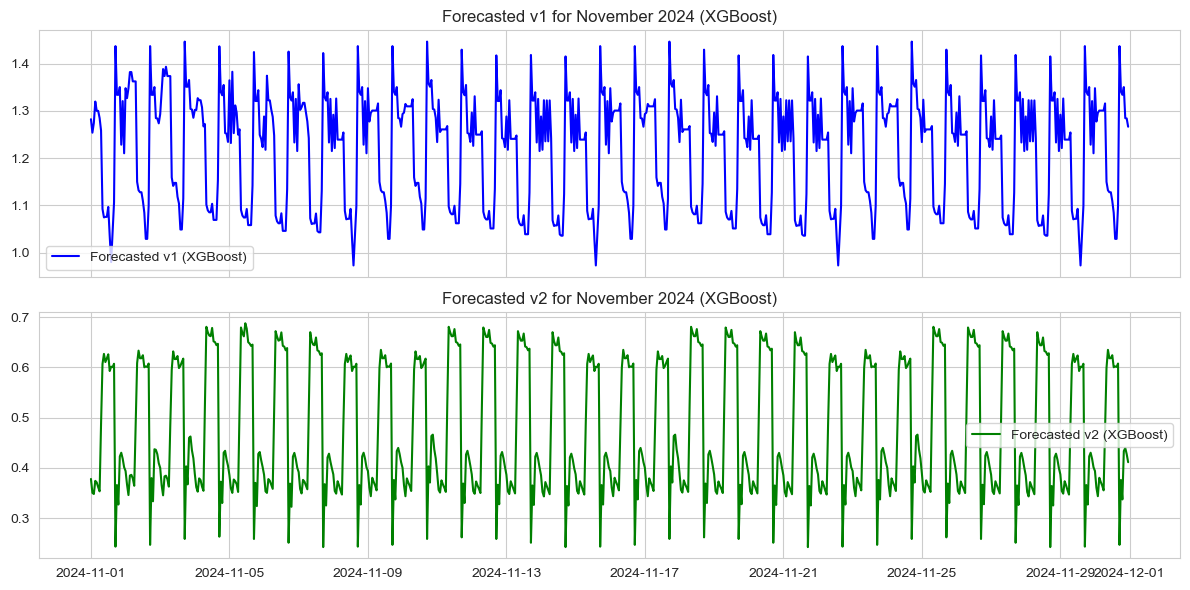

In [89]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(forecast_df_xgb.index, forecast_df_xgb['v1'], color='blue', label='Forecasted v1 (XGBoost)')
axes[0].set_title('Forecasted v1 for November 2024 (XGBoost)')
axes[0].legend()

axes[1].plot(forecast_df_xgb.index, forecast_df_xgb['v2'], color='green', label='Forecasted v2 (XGBoost)')
axes[1].set_title('Forecasted v2 for November 2024 (XGBoost)')
axes[1].legend()

plt.tight_layout()
plt.show()

# I like my graph for prediction because it is quite dense in the region where means/averages occur from november 2022 and 2023
# This is good visualizations, because my previous models results were way off from means of previous Novembers
# This is a result of 20 hours of work, I made sure to clean my final python file from all unnecasr

In [95]:
november_2022 = df.loc["2022-11-01":"2022-11-30"]
november_2023 = df.loc["2023-11-01":"2023-11-30"]

desc_nov_2022 = november_2022.describe()
desc_nov_2022

,v1,v2,month,hour,v1_lag_1,v2_lag_1,v1_lag_24,v2_lag_24,v1_lag_168,v2_lag_168,...,v1_roll_std_168,v2_roll_std_168,v1_roll_std_336,v2_roll_std_336,v1_diff_1,v2_diff_1,v1_diff_24,v2_diff_24,v1_diff_168,v2_diff_168
count,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,1.290413,0.373490,11.0,11.500000,-0.096672,-0.039233,-0.105380,-0.050536,0.089517,0.053615,...,1.176137,0.226172,1.386147,0.235279,-0.000276,-0.000070,0.010068,0.002507,-0.218414,-0.021162
std,1.179296,0.223045,0.0,6.926999,1.005621,0.982515,1.002698,0.980333,1.339405,1.067172,...,0.463078,0.018776,0.539999,0.024192,0.528745,0.101982,0.986811,0.170158,1.012858,0.137262
min,0.161684,0.036516,11.0,0.000000,-1.059499,-1.524065,-1.059240,-1.524028,-1.058017,-1.523560,...,0.719393,0.197456,0.789196,0.207094,-4.683264,-0.627313,-6.437378,-0.592763,-6.862275,-0.702317
25%,0.515450,0.176655,11.0,5.750000,-0.757804,-0.906688,-0.757591,-0.912194,-0.737909,-0.883156,...,0.839570,0.212194,0.844347,0.214408,-0.177682,-0.058864,-0.222209,-0.068052,-0.262140,-0.076492
50%,0.945308,0.349744,11.0,11.500000,-0.391217,-0.144150,-0.401481,-0.192083,-0.357061,-0.103586,...,0.854293,0.217745,1.459143,0.230394,-0.013430,0.001455,-0.014804,0.002080,-0.046904,-0.016396
75%,1.734126,0.537581,11.0,17.250000,0.281495,0.683356,0.229381,0.678479,0.387812,0.796094,...,1.807906,0.244345,1.982568,0.262529,0.168652,0.054222,0.158242,0.058481,0.086929,0.032023
max,8.754267,0.944145,11.0,23.000000,6.268340,2.474456,6.267479,2.474519,6.543153,2.574035,...,2.213305,0.276620,2.325464,0.281347,3.310932,0.413483,6.728128,0.699912,4.579213,0.506825


In [97]:
desc_nov_2023 = november_2023.describe()
desc_nov_2023

,v1,v2,month,hour,v1_lag_1,v2_lag_1,v1_lag_24,v2_lag_24,v1_lag_168,v2_lag_168,...,v1_roll_std_168,v2_roll_std_168,v1_roll_std_336,v2_roll_std_336,v1_diff_1,v2_diff_1,v1_diff_24,v2_diff_24,v1_diff_168,v2_diff_168
count,720.000000,720.000000,720.0,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,1.449824,0.410223,11.0,11.500000,0.038432,0.121482,0.028436,0.112130,0.054339,0.134959,...,0.896406,0.202062,0.997387,0.206341,0.000713,0.000182,0.012542,0.002316,-0.017706,-0.002900
std,0.938007,0.207968,0.0,6.926999,0.800170,0.916362,0.794387,0.912787,0.924524,0.919779,...,0.174501,0.011247,0.141958,0.007946,0.425820,0.094160,0.711389,0.161823,0.857580,0.143188
min,0.184194,0.048970,11.0,0.000000,-1.040302,-1.469199,-1.040046,-1.469162,-1.076848,-1.468715,...,0.624443,0.177263,0.759470,0.189500,-2.078726,-0.325929,-3.371102,-0.502905,-9.824859,-0.620624
25%,0.764845,0.250847,11.0,5.750000,-0.545117,-0.579837,-0.557139,-0.579794,-0.556418,-0.566558,...,0.829119,0.193528,0.925316,0.202151,-0.208075,-0.060309,-0.309478,-0.078658,-0.247712,-0.084281
50%,1.199157,0.379625,11.0,11.500000,-0.176459,-0.013978,-0.182510,-0.019041,-0.172370,0.011163,...,0.863135,0.203953,1.021172,0.208693,-0.010595,0.001291,-0.029240,-0.002425,0.021692,0.001062
75%,1.960094,0.576427,11.0,17.250000,0.474203,0.854491,0.468812,0.846442,0.442769,0.846026,...,1.018419,0.210132,1.065533,0.212304,0.208848,0.055935,0.278029,0.076940,0.285108,0.073632
max,5.265117,0.928665,11.0,23.000000,3.292759,2.406263,3.292353,2.406325,8.135480,2.466314,...,1.441408,0.225131,1.255446,0.223817,3.094997,0.310814,3.285024,0.529810,3.007497,0.507413
